# Setup

In [5]:
import json
import os
import sys
import string

sys.path.append('..')

import rasterio
from rasterio.enums import Resampling
import geopandas as gpd
import fiona

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

from utils import read_csv_non_utf

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']

# Grabbing population density raster
year = 2000
pop_dens_paths = config['indiv_data_paths']['human_pop_density']
human_pop_dens2000 = os.path.join(pop_dens_paths['base_path'], pop_dens_paths['data_path'].format(year, year))
pop_dens_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, human_pop_dens2000)

# Grabbing Benitez-Lopez
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

# Grabbing global protected areas - just one of the three files, to make things run quicker...
protected_areas_paths = config['indiv_data_paths']['protected_areas']
subset = protected_areas_paths['subsets'][0]
protected_areas_subset = os.path.join(protected_areas_paths['base_path'], protected_areas_paths['data_path'].format(subset))
PAs_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, protected_areas_subset)

# Loading population density raster

In [5]:
# Resampling the array for visualization: https://rasterio.readthedocs.io/en/stable/topics/resampling.html
#  - probably better practice to download pre-prepared lower resolution versions from NASA, but this works for now!
upscale_factor = 1 / 20

with rasterio.open(pop_dens_path) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape = (
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling = Resampling.average # seems the most reasonable resampling methods, since we're dealing with densities
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

data[data < 0] = np.nan # turning the fill value into NaN

# Plotting data

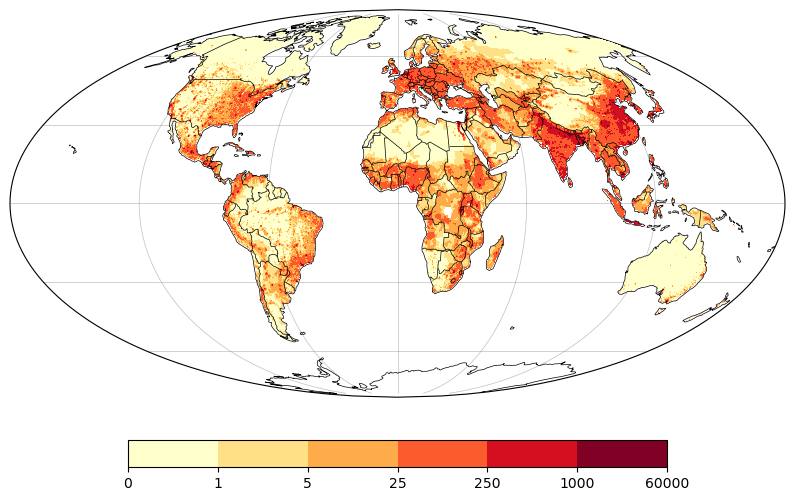

In [6]:
# Below code for color-mapping is from: https://stackoverflow.com/questions/61897393/unevenly-irregularly-spaced-data-for-colorbar-with-evenly-spaced-colors
uneven_levels = [0, 1, 5, 25, 250, 1000, 60000] # to match the SEDAC plot
cmap = plt.get_cmap('YlOrRd')
colors = cmap(np.linspace(0, 1, len(uneven_levels) - 1))
cmap, norm = mcolors.from_levels_and_colors(uneven_levels, colors)

# Setting things up for cartopy
xmin, ymin, xmax, ymax = list(dataset.bounds)

fig = plt.figure(figsize = (10, 14))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mollweide())
ax.add_feature(cartopy.feature.BORDERS, linewidth = 0.5, zorder = 20)
ax.add_feature(cartopy.feature.COASTLINE, linewidth = 0.5, zorder = 20)

gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = False, linewidth = 0.5, color = 'gray', alpha = 0.5, zorder = 0)

# Plotting the data
im = ax.imshow(data.squeeze(), 
               cmap = cmap, norm = norm, 
               origin = 'upper', transform = ccrs.PlateCarree(), extent = [xmin, xmax, ymin, ymax],
               zorder = 10)

plt.colorbar(im, ax = ax, fraction = 0.025, pad = 0.04, orientation = 'horizontal')

# plt.savefig('/Users/emiliolr/Desktop/pop_density_map.png', bbox_inches = 'tight', dpi = 300)
plt.show();

# Extracting pixel values for a study location

For population density data, we don't need to re-project the coordinates since the data is already in WGS84 format. For others, we might need to project the desired lat/lon into coordinates for the data's CRS, then index.

In [7]:
# Grabbing a window around a desired lat/lon for a sanity check 
lat, lon = 38.8816, -77.0910 # Arlington, VA
N = 800

with rasterio.open(pop_dens_path) as dataset:
    py, px = dataset.index(lon, lat)
    window = rasterio.windows.Window(px - N // 2, py - N // 2, N, N)
    clip = dataset.read(1, window = window)

clip[clip < 0] = np.nan

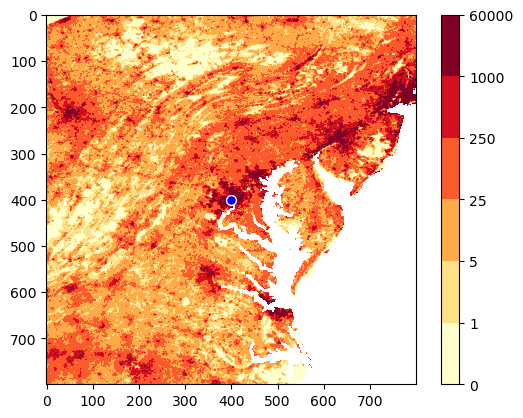

In [8]:
# Plotting the window which should be centered on Arlington, VA (blue dot) - looks correct to me!
plt.scatter([N // 2], [N // 2], s = 50, c = 'blue', edgecolor = 'white', zorder = 10)
plt.imshow(clip, cmap = cmap, norm = norm, zorder = 0)
plt.colorbar();

## Trying to extend the above to a script using Benitez-Lopez study locations

**TODO:**
- [x] Grab the correct version of the dataset based on the study year (where is study year recorded?)
- [ ] Figure out a better method for extracting the year (publication year may not be close to when the data was collected...)
- [ ] Download [GRUMPv1](https://sedac.ciesin.columbia.edu/data/collection/grump-v1) and use this for 1990 and 1995
   - I imagine the reason why we're not doing great right now on matching the reference values is in part due to thhe fact that we only use [GPWv4](https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-rev11) values 

In [9]:
def match_to_closest_year(avail_years, study_years):
    
    study_years = np.array(study_years).reshape(-1, 1)
    study_years = np.repeat(study_years, len(avail_years), axis = 1)
    
    avail_years = np.array(avail_years).reshape(1, -1)
    
    diff = np.abs(study_years - avail_years)
    closest_idx = np.argmin(diff, axis = 1)
    closest_idx = [[0 for i in range(len(closest_idx))], list(closest_idx)]
    
    matched_years = avail_years[closest_idx[0], closest_idx[1]]
    
    return matched_years

In [10]:
def extract_year(ref_str):
    year = ref_str.split(' ')[-1].strip()
    year = ''.join([c for c in year if c.isnumeric()])
    year = int(year)

    return year

In [11]:
# Read in hunting effects dataset
ben_lop2019 = read_csv_non_utf(ben_lop_path)

#  removing spatial predictors - pretending we haven't extracted them yet
cols = ['Reference', 'Study', 'Order', 'Family', 'Species', 'ratio', 
        'RR', 'X', 'Y', 'Region', 'Country', 'BM', 'Diet']
ben_lop2019 = ben_lop2019[cols]

#  grabbing year - for now, just using the publication year...
ben_lop2019['Study_Year'] = ben_lop2019['Reference'].apply(extract_year)
ben_lop2019.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,Study_Year
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,2006
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,2006
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,2006
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,2006
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,2006


In [14]:
# Matching study years to closest year for the population density dataset
study_years = list(ben_lop2019['Study_Year'])
avail_years = pop_dens_paths['avail_years']
dataset_years = match_to_closest_year(avail_years, study_years)

In [140]:
# Read in all datasets that we'll need in FULL resolution
pop_dens_data = {}

for year in np.unique(dataset_years):
    data_path = os.path.join(pop_dens_paths['base_path'], pop_dens_paths['data_path'].format(year, year))
    data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, human_pop_dens2000)
    
    with rasterio.open(data_path) as dataset:
        data = dataset.read(1)
    
    data[data < 0] = np.nan
    
    pop_dens_data[year] = {}
    pop_dens_data[year]['dataset'] = dataset
    pop_dens_data[year]['data'] = data

In [143]:
# Running through the study locations and grabbing corresponding pixel values from the raster
pop_dens_col = []

for year, lat, lon in zip(dataset_years, ben_lop2019['Y'], ben_lop2019['X']):
    data = pop_dens_data[year]['data']
    dataset = pop_dens_data[year]['dataset']
    
    row, col = dataset.index(lon, lat)
    pop_dens_col.append(data[row, col])

pop_dens_col = np.array(pop_dens_col)

In [169]:
ref_pop_dens = read_csv_non_utf(ben_lop_path)['PopDens']
mae = np.mean(np.abs((pop_dens_col - ref_pop_dens)))
print(f'Using our extraction method, we achieve a MAPE of {round(mae, 3)}')

Using our extraction method, we achieve a MAPE of 4.611


# Turning vector data into raster data

In [11]:
# Adapted from: https://gis.stackexchange.com/questions/220023/only-read-specific-rows-of-a-shapefile-with-geopandas-fiona
def read_gpd_subset(filename, num_entries = 100):
    with fiona.open(filename) as source:
        for feature in source[ : num_entries]:
            yield feature

In [13]:
# Loading in protected area polygons (vector data)
pa_data_subset = gpd.GeoDataFrame.from_features(read_gpd_subset(PAs_path))
pa_data_subset.head()

,geometry,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,...,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ
0,"POLYGON ((-61.82494 17.18497, -61.82497 17.184...",1.0,1,1,Diamond Reef and Salt Fish Tail Reef,Diamond Reef,Marine Reserve,Marine Reserve,National,Ia,...,State,Fisheries Division,Not Reported,State Verified,1807,AG-04,ATG,ATG,Not Applicable,Not Applicable
1,"POLYGON ((-61.74007 17.52001, -61.77174 17.526...",2.0,2,1,Palaster Reef,Palaster Reef,Marine Reserve,Marine Reserve,National,Ia,...,State,Fisheries Division,Not Reported,State Verified,1807,AG-10,ATG,ATG,Not Applicable,Not Applicable
2,"POLYGON ((-65.98955 -22.47423, -65.99441 -22.4...",3.0,3,1,Laguna de los Pozuelos,Laguna de los Pozuelos,Monumento Natural,Nature Monument,National,III,...,Not Reported,Administración de Parques Nacionales,Not Reported,State Verified,1935,AR-Y,ARG,ARG,Not Applicable,Not Applicable
3,"POLYGON ((-61.83791 -24.20686, -61.83781 -24.2...",4.0,4,1,Formosa,Formosa,Reserva Natural,Nature Reserve,National,Ia,...,Not Reported,Administración de Parques Nacionales,https://sib.gob.ar/archivos/plan_de_gestion_RN...,State Verified,1935,AR-P,ARG,ARG,Not Applicable,Not Applicable
4,"POLYGON ((-73.14850 -49.27008, -73.14368 -49.2...",6.0,6,1,Los Glaciares,Los Glaciares,Parque Nacional,National Park,National,II,...,Not Reported,Administración de Parques Nacionales,https://sib.gob.ar/archivos/PG_PN_LOS_GLACIARE...,State Verified,1935,AR-Z,ARG,ARG,Not Applicable,Not Applicable


In [20]:
pa_data_subset['geometry'].iloc[95]